# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility

In [2]:
from tqdm import tqdm

In [3]:
def softmax(x, temp):
    exps = np.exp((x - np.max(x)) / temp)
    return exps / np.sum(exps)

In [4]:
class SARSA:
  def __init__(self, env, alpha, gamma, temp):
      self.env = env
      self.alpha = alpha
      self.gamma = gamma
      self.temp = temp
      self.Q = np.zeros((env.observation_space.n, env.action_space.n))


  def select_action(self, s, greedy=False):  
      # write your solution here
      if greedy:
          return np.argmax(self.Q[s])
      else:
          action_probs = softmax(self.Q[s], self.temp)
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):
      target = r + self.gamma * self.Q[s_prime, a_prime] * (not done)
      td_error = target - self.Q[s, a]
      self.Q[s, a] += self.alpha * td_error


class ExpectedSARSA:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
      self.env = env
      self.alpha = alpha
      self.gamma = gamma
      self.temp = temp
      self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  def select_action(self, s, greedy=False):
      # write your solution here
      if greedy:
          return np.argmax(self.Q[s])
      else:
          action_probs = softmax(self.Q[s], self.temp)
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):

      # write your solution here
      action_probs = softmax(self.Q[s_prime], self.temp)
      expected_q = np.sum(action_probs * self.Q[s_prime])
      target = r + self.gamma * expected_q * (not done)
      td_error = target - self.Q[s, a]
      self.Q[s, a] += self.alpha * td_error

# bonus question, optional
class Hybrid_SARSA_Q:
  def __init__(self, env, alpha, gamma, temp, beta):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp  # Temperature for softmax
    self.beta = beta  # Mixing factor
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-table
  
  def select_action(self, s, greedy=False):
    # write your solution here
      if greedy:
          return np.argmax(self.Q[s])  # Choose the best action for evaluation
      else:
          action_probs = softmax(self.Q[s], self.temp)  # Use softmax for exploration
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
      # Calculate the target with a mixture of max Q and expected Q
      max_q_prime = np.max(self.Q[s_prime])
      action_probs_prime = softmax(self.Q[s_prime], self.temp)
      expected_q_prime = np.sum(action_probs_prime * self.Q[s_prime])
      target = r + self.gamma * ((1 - self.beta) * max_q_prime + self.beta * expected_q_prime) * (not done)

      # TD error
      td_error = target - self.Q[s, a]

      # Q-table update
      self.Q[s, a] += self.alpha * td_error

# Write your experiment code below


In [5]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
env = StepAPICompatibility(env)#, new_step_api=True)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


## Sarsa performance


In [9]:
# Parameters
alpha_values = [0.1,0.2,0.5]
temp_values = [0.005,0.01,0.02]
trials = 10
segments = 500
episodes_per_segment = 10  # Training episodes
testing_episode = 1  # Testing episodes per segment

# Initialize the environment
env = gym.make(env_name)

In [10]:
# function that runs each episode
def run_experiment(agent_class, env, alpha, temp, segments=500, episodes_per_segment=10, trials=10):
    """
    Run complete experiment for given agent and parameters.
    
    This function runs multiple trials of the learning process, each consisting of
    multiple segments, where each segment contains training episodes followed by
    a testing episode.
    
    Args:
        agent_class: Class of the RL agent (SARSA or Expected SARSA)
        env: OpenAI Gym environment
        alpha (float): Learning rate
        temp (float): Temperature parameter
        segments (int): Number of segments to run
        episodes_per_segment (int): Number of training episodes per segment
        trials (int): Number of independent trials to run
    
    Returns:
        tuple: (training_results, testing_results) containing performance data
    """
    training_results = np.zeros((trials, segments))
    testing_results = np.zeros((trials, segments))
    
    for trial in tqdm(range(trials)):
        # Initialize new agent for each trial
        agent = agent_class(env, alpha, gamma=0.99, temp=temp)
        
        for segment in range(segments):
            segment_rewards = []
            
            # Training episodes
            for _ in range(episodes_per_segment):
                state, _ = env.reset()
                done = False
                total_reward = 0
                
                while not done:
                    # Select and execute action
                    action = agent.select_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated
                    
                    # Select next action and update agent
                    next_action = agent.select_action(next_state)
                    agent.update(state, action, reward, next_state, next_action, done)
                    
                    state = next_state
                    action = next_action
                    total_reward += reward
                
                segment_rewards.append(total_reward)
            
            # Store average training performance for this segment
            training_results[trial, segment] = np.mean(segment_rewards)
            
            # Testing episode (greedy policy)
            state, _ = env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = agent.select_action(state, greedy=True)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                total_reward += reward
            
            testing_results[trial, segment] = total_reward
    
    return training_results, testing_results




Running SARSA with alpha=0.1, temp=0.005


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]



Running Expected SARSA with alpha=0.1, temp=0.005


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]



Running SARSA with alpha=0.1, temp=0.01


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]



Running Expected SARSA with alpha=0.1, temp=0.01


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]



Running SARSA with alpha=0.1, temp=0.02


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]



Running Expected SARSA with alpha=0.1, temp=0.02


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]



Running SARSA with alpha=0.2, temp=0.005


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]



Running Expected SARSA with alpha=0.2, temp=0.005


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]



Running SARSA with alpha=0.2, temp=0.01


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]



Running Expected SARSA with alpha=0.2, temp=0.01


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]



Running SARSA with alpha=0.2, temp=0.02


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]



Running Expected SARSA with alpha=0.2, temp=0.02


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]



Running SARSA with alpha=0.5, temp=0.005


100%|██████████| 10/10 [00:47<00:00,  4.76s/it]



Running Expected SARSA with alpha=0.5, temp=0.005


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]



Running SARSA with alpha=0.5, temp=0.01


100%|██████████| 10/10 [00:49<00:00,  4.95s/it]



Running Expected SARSA with alpha=0.5, temp=0.01


100%|██████████| 10/10 [00:59<00:00,  5.98s/it]



Running SARSA with alpha=0.5, temp=0.02


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]



Running Expected SARSA with alpha=0.5, temp=0.02


100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


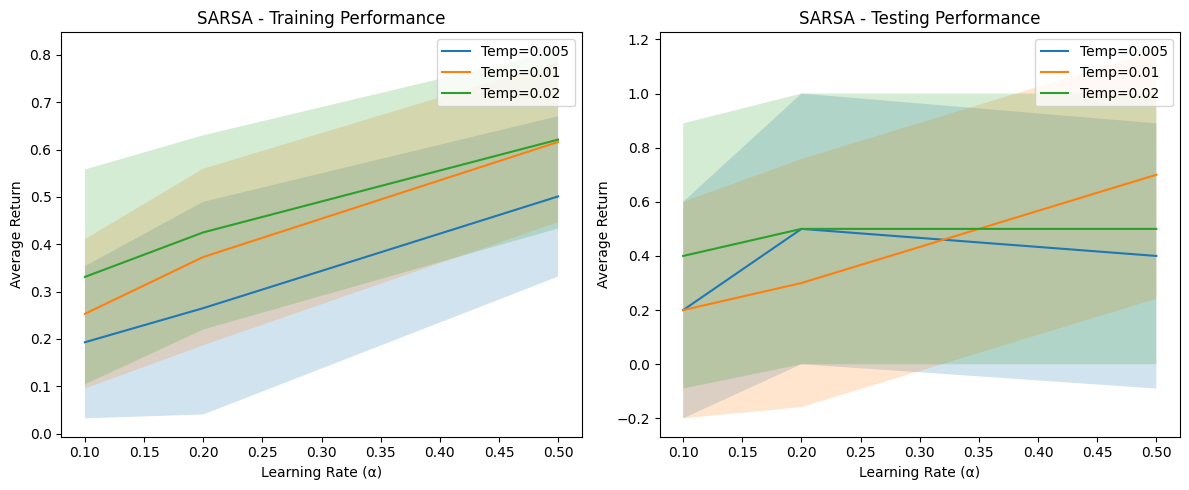

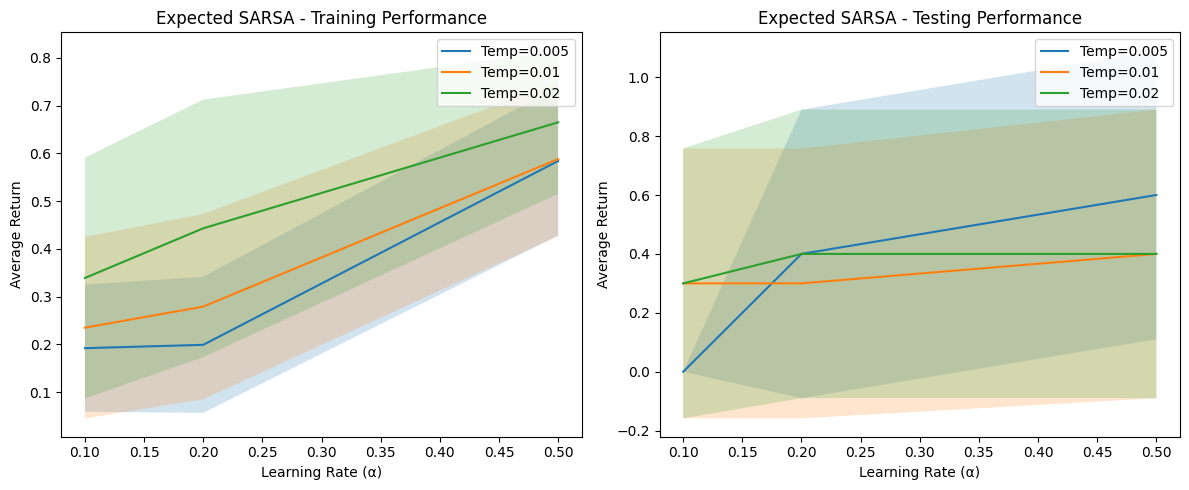

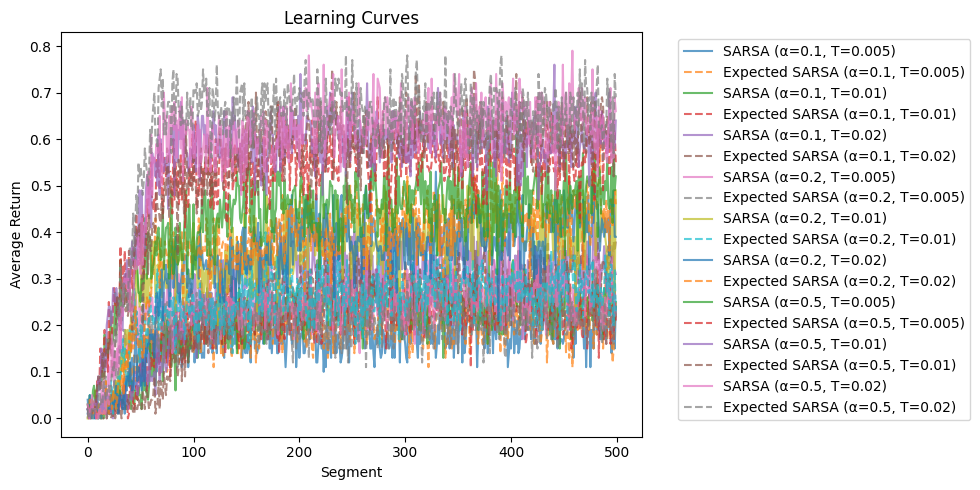

In [11]:
# Storage for results
sarsa_results = {
    'training': np.zeros((len(alpha_values), len(temp_values), 10, 500)),
    'testing': np.zeros((len(alpha_values), len(temp_values), 10, 500))
}

expected_sarsa_results = {
    'training': np.zeros((len(alpha_values), len(temp_values), 10, 500)),
    'testing': np.zeros((len(alpha_values), len(temp_values), 10, 500))
}

# Run experiments for each hyperparameter setting
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        print(f"\nRunning SARSA with alpha={alpha}, temp={temp}")
        train_results, test_results = run_experiment(SARSA, env, alpha, temp)
        sarsa_results['training'][i, j] = train_results
        sarsa_results['testing'][i, j] = test_results
        
        print(f"\nRunning Expected SARSA with alpha={alpha}, temp={temp}")
        train_results, test_results = run_experiment(ExpectedSARSA, env, alpha, temp)
        expected_sarsa_results['training'][i, j] = train_results
        expected_sarsa_results['testing'][i, j] = test_results

# Plot results
def plot_results(results, title, alpha_values, temp_values):
    plt.figure(figsize=(12, 5))
    
    # Training performance
    plt.subplot(1, 2, 1)
    for i, temp in enumerate(temp_values):
        mean_perf = np.mean(results['training'][:, i, :, -10:], axis=(1, 2))
        std_perf = np.std(results['training'][:, i, :, -10:], axis=(1, 2))
        plt.plot(alpha_values, mean_perf, label=f'Temp={temp}')
        plt.fill_between(alpha_values, 
                        mean_perf - std_perf, 
                        mean_perf + std_perf, 
                        alpha=0.2)
    plt.title(f'{title} - Training Performance')
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Average Return')
    plt.legend()
    
    # Testing performance
    plt.subplot(1, 2, 2)
    for i, temp in enumerate(temp_values):
        mean_perf = np.mean(results['testing'][:, i, :, -1], axis=1)
        std_perf = np.std(results['testing'][:, i, :, -1], axis=1)
        plt.plot(alpha_values, mean_perf, label=f'Temp={temp}')
        plt.fill_between(alpha_values, 
                        mean_perf - std_perf, 
                        mean_perf + std_perf, 
                        alpha=0.2)
    plt.title(f'{title} - Testing Performance')
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Average Return')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot results for both algorithms
plot_results(sarsa_results, 'SARSA', alpha_values, temp_values)
plot_results(expected_sarsa_results, 'Expected SARSA', alpha_values, temp_values)

# Learning curves
plt.figure(figsize=(10, 5))
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        mean_sarsa = np.mean(sarsa_results['training'][i, j], axis=0)
        mean_expected = np.mean(expected_sarsa_results['training'][i, j], axis=0)
        
        plt.plot(mean_sarsa, label=f'SARSA (α={alpha}, T={temp})', 
                linestyle='-', alpha=0.7)
        plt.plot(mean_expected, label=f'Expected SARSA (α={alpha}, T={temp})', 
                linestyle='--', alpha=0.7)

plt.title('Learning Curves')
plt.xlabel('Segment')
plt.ylabel('Average Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

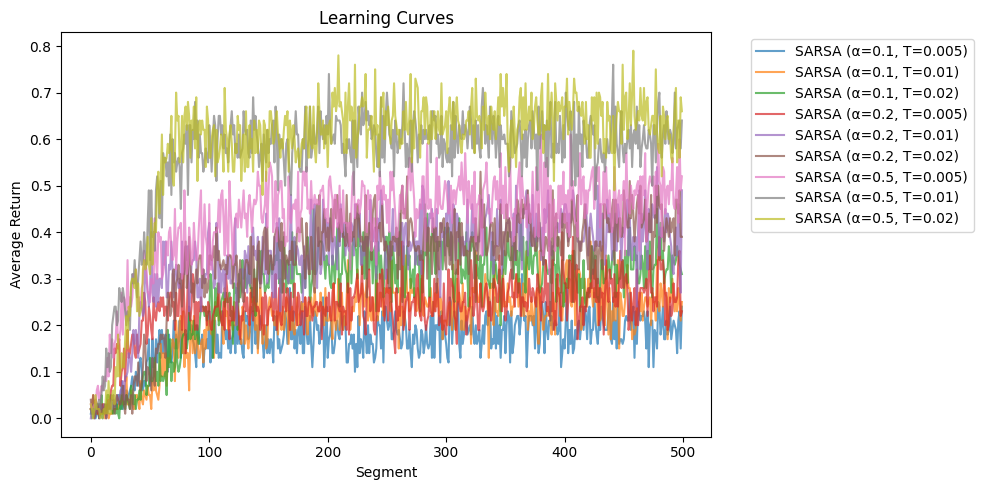

In [12]:
# Learning curves
plt.figure(figsize=(10, 5))
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        mean_sarsa = np.mean(sarsa_results['training'][i, j], axis=0)
        mean_expected = np.mean(expected_sarsa_results['training'][i, j], axis=0)
        
        plt.plot(mean_sarsa, label=f'SARSA (α={alpha}, T={temp})', 
                linestyle='-', alpha=0.7)
        # plt.plot(mean_expected, label=f'Expected SARSA (α={alpha}, T={temp})', 
        #         linestyle='--', alpha=0.7)

plt.title('Learning Curves')
plt.xlabel('Segment')
plt.ylabel('Average Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

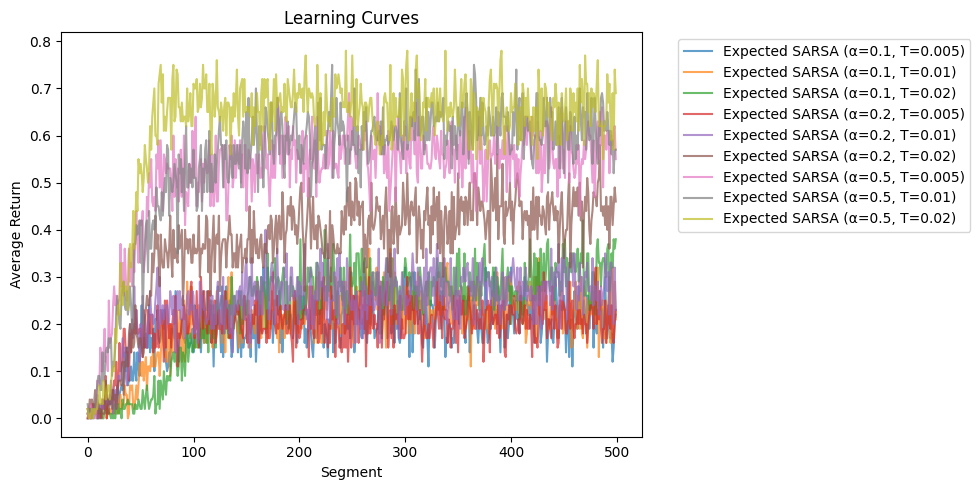

In [14]:
# Learning curves
plt.figure(figsize=(10, 5))
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        mean_expected = np.mean(expected_sarsa_results['training'][i, j], axis=0)
        
        plt.plot(mean_expected, label=f'Expected SARSA (α={alpha}, T={temp})', 
                linestyle='-', alpha=0.7)

plt.title('Learning Curves')
plt.xlabel('Segment')
plt.ylabel('Average Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

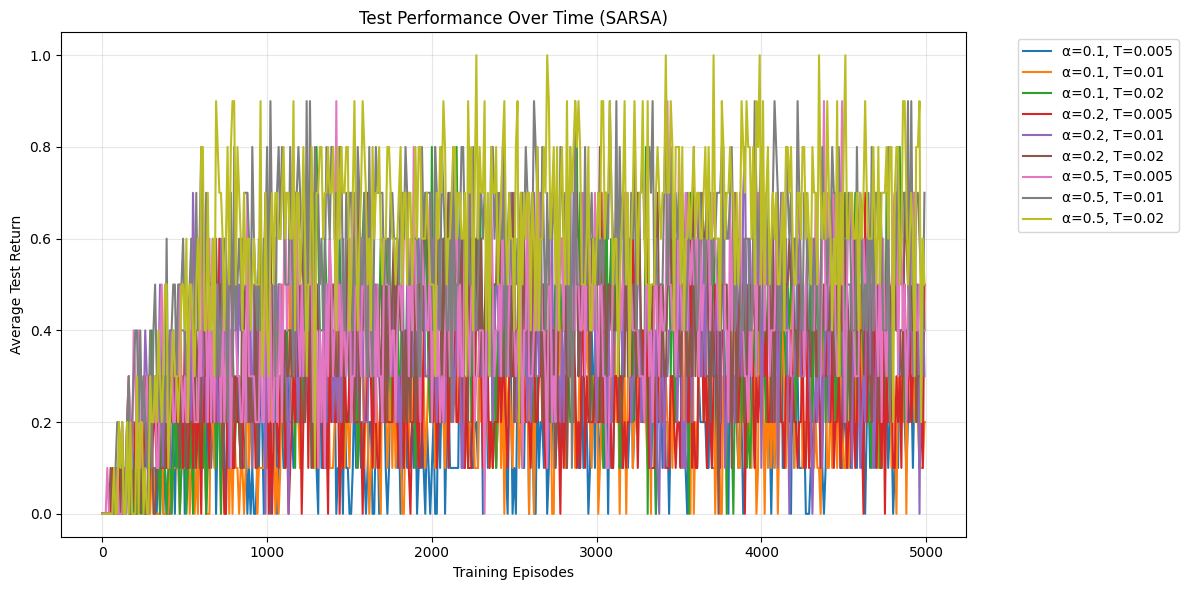

In [20]:
# Plot test performance over time
plt.figure(figsize=(12, 6))
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        # Average test performance across trials
        mean_sarsa_test = np.mean(sarsa_results['testing'][i, j], axis=0)
        plt.plot(np.arange(500) * 10, mean_sarsa_test, 
                label=f'α={alpha}, T={temp}',
                linestyle='-')

plt.title('Test Performance Over Time (SARSA)')
plt.xlabel('Training Episodes')
plt.ylabel('Average Test Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Visualization code
def plot_learning_curves(results, alpha_values, temp_values, title):
    """
    Create detailed learning curves with error bands for all parameter combinations.
    
    Args:
        results (dict): Dictionary containing training and testing results
        alpha_values (list): List of learning rates used
        temp_values (list): List of temperature values used
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Define base colors for different learning rates
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, alpha in enumerate(alpha_values):
        # Create color gradients for different temperatures
        for j, temp in enumerate(temp_values):
            # Calculate statistics across trials
            mean_returns = np.mean(results['training'][i, j], axis=0)
            std_error = np.std(results['training'][i, j], axis=0) / np.sqrt(10)
            
            # Scale x-axis by episodes per segment
            episodes = np.arange(len(mean_returns)) * 10
            
            # Convert base color to RGB for manipulation
            base_color = np.array(plt.matplotlib.colors.to_rgb(base_colors[i]))
            # Create darker shades for higher temperatures (multiply RGB values)
            shade_factor = 1 - (j * 0.3)  # Darker for higher temperatures
            color = base_color * shade_factor
            
            # Plot mean line with confidence bands
            plt.plot(episodes, mean_returns, 
                    label=f'α={alpha}, T={temp}',
                    color=color,
                    linewidth=2)
            
            plt.fill_between(episodes, 
                            mean_returns - std_error,
                            mean_returns + std_error,
                            color=color,
                            alpha=0.1)
    
    plt.title(f'{title}\n(Averaged over 10 trials, 10 episodes per segment)')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Return per Segment')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

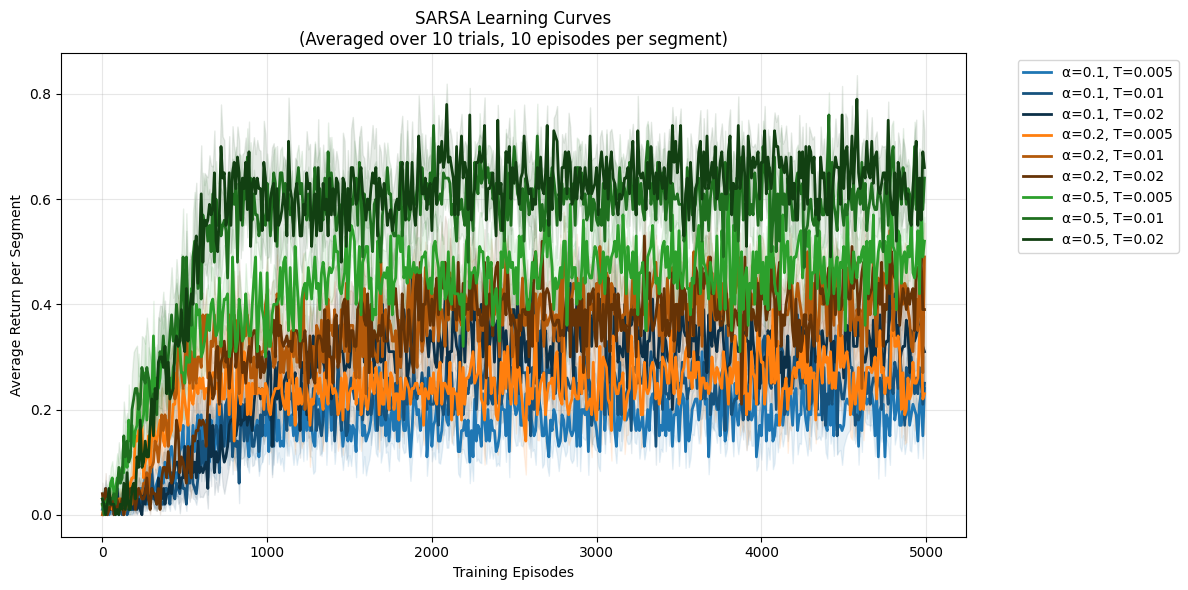

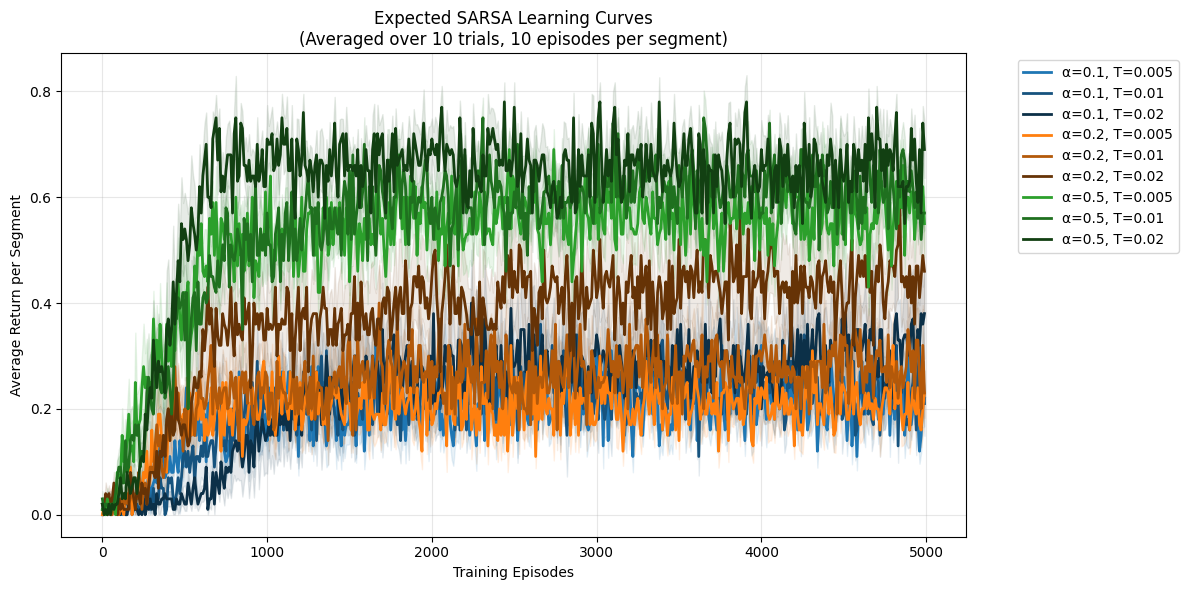

In [23]:
# Plot learning curves for both algorithms
plot_learning_curves(sarsa_results, alpha_values, temp_values, 'SARSA Learning Curves')
plot_learning_curves(expected_sarsa_results, alpha_values, temp_values, 'Expected SARSA Learning Curves')